In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Imports

In [2]:
from google.colab import drive, files # google colab specific
import requests
import pandas as pd
import os
import warnings
import sys
import matplotlib.pyplot as plt
import json
import time


In [3]:
sys.setrecursionlimit(10000000) # Prevent infinite recursion (https://www.geeksforgeeks.org/python-sys-setrecursionlimit-method/)

# 2. API Key
API key goes here, add your own key. <br>
Found here: https://estated.com/developers/docs/v4

In [4]:
estated_api_key = '6pc7nBaZug5BvQdv9eJMcUylvFt8Cu'

# 3. Estated Request and Response
`get_estated_detail()` implementation

Credit: https://www.youtube.com/watch?v=HxdGS48cdSU&t=506s&ab_channel=AnalyticsAriel





In [5]:
def get_estated_detail(api_key, 
                       street_address, 
                       city, 
                       state, 
                       zip_code):
  # sample API get request
  base_url = 'https://apis.estated.com/v4/property'

  params = (
      ('token', estated_api_key),
      ('street_address', street_address),
      ('city', city),
      ('state', state),
      ('zip_code', zip_code),
  )

  response = requests.get(base_url, params=params)
  return response

# 4. Create Dataframe using Address Data

In [64]:
# Read in the addresses from the csv files and store them into a dataframe

df_addresses = pd.read_csv('/content/zillow_addresses_stPete.csv')
df_addresses = df_addresses.rename(columns={"stPete_addresses" : "address"})

# clear null values
df_addresses_clean = df_addresses[df_addresses['address'].notnull()]
# drop some invalid entries
df_addresses_clean = df_addresses_clean.drop(70)
df_addresses_clean = df_addresses_clean.drop(77)
df_addresses_clean = df_addresses_clean.drop(99)
# reset index 
df_addresses_clean = df_addresses_clean.reset_index(drop=True)


In [41]:
# Manual Testing
# create a dataframe
#d = {'address': ['9307 crandon lane, tampa, FL 33635', '310 72nd Ave N, Saint Petersburg, FL 33702', '135 NW Monroe Cir N, Saint Petersburg, FL 33702', '6990 18th St S, Saint Petersburg, FL 33712', '5718 18th Ave N, Saint Petersburg, FL 33710', '115 112th Ave NE APT 1027, Saint Petersburg, FL 33716', '4600 Dr Martin Luther King Jr St N, Saint Petersburg, FL 33703', '6420 6th Ave N, Saint Petersburg, FL 33710', '5386 Alhambra Way S, Saint Petersburg, FL 33712', '7403 46th Ave N LOT 274, Saint Petersburg, FL 33709', '3125 54th Ave N, Saint Petersburg, FL 33714'   ]}
#d = {'address': ['9307 crandon lane, tampa, FL 33635', '310 72nd Ave N, Saint Petersburg, FL 33702']}#, '310 72nd Ave N, Saint Petersburg, FL 33702', '135 NW Monroe Cir N, Saint Petersburg, FL 33702' ]}
#_df_addresses = pd.DataFrame(data=d)
#_df_addresses

,address
0,"9307 crandon lane, tampa, FL 33635"
1,"310 72nd Ave N, Saint Petersburg, FL 33702"


# 5. Supply Address to Dataframe
Credit: analysticsariel

In [69]:
# split dataframe into sub address elements
df_addresses = df_addresses_clean.copy()

df_addresses['street'] = df_addresses.apply(lambda x: x['address'].split(',')[0], axis=1)
df_addresses['city'] = df_addresses.apply(lambda x: x['address'].split(',')[1].strip(), axis=1)
df_addresses['state'] = df_addresses.apply(lambda x: x['address'].split(',')[2].split()[0], axis=1)
df_addresses['zip_code'] = df_addresses.apply(lambda x: x['address'].split(',')[2].split()[1], axis=1)
df_addresses

,address,street,city,state,zip_code
0,"1162 37th Ave N, Saint Petersburg, FL 33704",1162 37th Ave N,Saint Petersburg,FL,33704
1,"7913 9th Ave S, Saint Petersburg, FL 33707",7913 9th Ave S,Saint Petersburg,FL,33707
2,"10263 Gandy Blvd N APT 102, Saint Petersburg, ...",10263 Gandy Blvd N APT 102,Saint Petersburg,FL,33702
3,"1769 38th Ave N, Saint Petersburg, FL 33713",1769 38th Ave N,Saint Petersburg,FL,33713
4,"5262 3rd Ave S, Saint Petersburg, FL 33707",5262 3rd Ave S,Saint Petersburg,FL,33707
...,...,...,...,...,...
82,"3301 58th Ave N #110, Saint Petersburg, FL 33714",3301 58th Ave N #110,Saint Petersburg,FL,33714
83,"6857 49th Ave N, Saint Petersburg, FL 33709",6857 49th Ave N,Saint Petersburg,FL,33709
84,"555 5th Ave NE #1302, Saint Petersburg, FL 33701",555 5th Ave NE #1302,Saint Petersburg,FL,33701
85,"22 Franklin Ct S #C, Saint Petersburg, FL 33711",22 Franklin Ct S #C,Saint Petersburg,FL,33711


# 6. Call `get_estated_detail()`

In [70]:
# get estated property detail per address
response_list = []

# iterate through rows in the dataframe (table)
for index, row in df_addresses.iterrows():
  
  # get parameters
  address = row['address']
  street = row['street']
  city = row['city']
  state = row['state']
  zip_code = row['zip_code']
  
  # get api response
  print('Getting data for address: {0}'.format(address))
  time.sleep(10)
  response = get_estated_detail(estated_api_key, 
                        street, 
                        city, 
                        state, 
                        zip_code)
  # append to list
  response_list.append(response.json())

  response.json()

Getting data for address: 1162 37th Ave N, Saint Petersburg, FL 33704
Getting data for address: 7913 9th Ave S, Saint Petersburg, FL 33707
Getting data for address: 10263 Gandy Blvd N APT 102, Saint Petersburg, FL 33702


KeyboardInterrupt: ignored

# 7. Data Cleaning


1. Normalize required columns.
2. Drop unnneccessary columns.
3. Rename remaining columns.
4. Configure date to support monthly or yearly increments.
5. Change types to work with resampling.
6. Mitigate null values.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


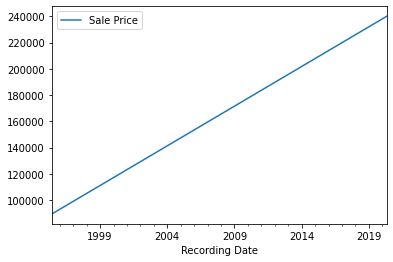

In [ ]:
# Read each individual json response that was appended to the response list and store them in a dataframe

#for k in range(len(response_list)):
 #   df2 = df2.append(pd.json_normalize(response_list[k]["data"]["address"]))
 
# Set response
d = response.json()

# Normalize, drop unnecessary columns and rename others.
df5 = pd.json_normalize(d['data']['deeds'])
df5 = df5.drop(['document_type',
                'buyer_unit_number',
                'buyer_unit_type',
                'buyer_city',
                'buyer_address',
                'buyer2_last_name',
                'buyer2_first_name',
                'buyer_last_name',
                'buyer_first_name',
                'seller_zip_plus_four_code',
                'seller_zip_code',
                'seller_state',
                'seller_city',
                'seller_unit_number',
                'seller_address',
                'seller2_last_name',
                'seller2_first_name',
                'seller_last_name',
                'seller_first_name',
                'real_estate_owned',
                'original_contract_date',
                'deed_book',
                'deed_page',
                'document_id',
                'sale_price_description',
                'transfer_tax',
                'distressed_sale',
                'buyer_state',
                'buyer_zip_code',
                'buyer_zip_plus_four_code',
                'lender_name',
                'lender_type',
                'loan_amount',
                'loan_type',
                'loan_due_date',
                'loan_finance_type',
                'loan_interest_rate'], 
                axis = 1)
df5 = df5.rename(columns={"recording_date": "Recording Date", 
                          "sale_price": "Sale Price"})

# Change date to support monthly increments.
df5['Recording Date'][0] = '2020-05-31'
df5['Recording Date'][1] = '1995-06-30'

# Change column type from object to datetime for resampling.
df5['Recording Date'] = pd.to_datetime(df5['Recording Date'])
df5['Sale Price'] = pd.to_numeric(df5['Sale Price'])

# Set index
df5 = df5.set_index('Recording Date')
df5.index = df5.index.to_period("1M")

# Resample and interpolate to fill null values.
df5 = df5.resample('1M').interpolate()

df5.plot()

# 7.1 Shiller Data

In [ ]:
# Get Shiller data
shiller_filePath = "/content/drive/MyDrive/GitHub/jphomevalue/data/TPXRSA.csv"
shiller_data = pd.read_csv(shiller_filePath, header = 0)

# Convert date and set index to datetime
shiller_data['DATE'] = pd.to_datetime(shiller_data['DATE'])
shiller_data = shiller_data.set_index('DATE')

# Set period and interpolate
shiller_data.index = shiller_data.index.to_period("1M")
shiller_data = shiller_data.resample('1M').interpolate()

# 8. Plot Clean Data (example)

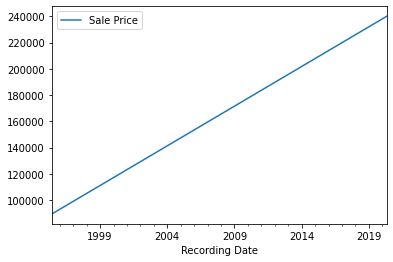

In [ ]:
df5.plot()

# 9. Repeat section 7 for other Dataframes

In [ ]:
# df1 = pd.json_normalize(d['data']['assessments'])
# df1 = df1.rename(columns={"year": "Tax year", "land_value": "Land value", "improvement_value": "Improvement value","total_value":"Total tax value"})

# # pd.json_normalize(d['data']['address'])

# df2 = pd.json_normalize(d['data']['address'])
# df2 = df2.drop(['street_number','street_post_direction','street_pre_direction','street_name','street_suffix','carrier_code','latitude','longitude','geocoding_accuracy','census_tract'], axis = 1)
# df2 = df2.rename(columns={"unit_type": "Unit Type", "unit_number": "Unit Number", "formatted_street_address": "Street Address","city": "City","state": "State","zip_code": "Zip Code","zip_plus_four_code": "Zip Plus Four Code"})

# # pd.json_normalize(d['data']['valuation'])

# df3 = pd.json_normalize(d['data']['valuation'])
# df3 = df3.rename(columns={"value": "Estated current property value", "high": "Estated highest probable value", "low": "Estated lowest probable value","forecast_standard_deviation": "Forecast standard deviation","date": "Date"})

# # pd.json_normalize(d['data']['structure'])

# df4 = pd.json_normalize(d['data']['structure'])
# df4 = df4.drop(['plumbing_fixtures_count','interior_wall_type','water_type','sewer_type','other_areas','other_rooms','other_features','other_improvements','amenities','basement_type','fireplaces','air_conditioning_type','heating_fuel_type','heating_type','roof_style_type','roof_material_type','foundation_type','exterior_wall_type','pool_type'], axis = 1)
# df4 = df4.rename(columns={"year_built": "Year built", "effective_year_built": "Effective year built", "stories": "Stories","rooms_count": "Rooms count","beds_count": "Beds","baths": "Baths","partial_baths_count": "Partial baths","units_count": "Units count","parking_type": "Parking type","parking_spaces_count": "Parking spaces","architecture_type": "Architecture type","construction_type": "Construction type", "quality": "Quality", "condition": "Condition", "flooring_types": "Flooring types","total_area_sq_ft": "Total area sq ft."})


# 10. Concat Dataframes and Set Axis

In [ ]:
pdList = [shiller_data, df5]  # List of your dataframes
new_df = pd.concat(pdList, axis = 1)

# Print new dataframe
new_df

,TPXRSA,Sale Price
1995-06,NaN,89500.000000
1995-07,NaN,90003.344482
1995-08,NaN,90506.688963
1995-09,NaN,91010.033445
1995-10,NaN,91513.377926
...,...,...
2021-08,296.829882,NaN
2021-09,304.124715,NaN
2021-10,309.713391,NaN
2021-11,315.997613,NaN


# Download Dataframe CSV

In [ ]:
# download

new_df.to_csv('estated_output.csv')
files.download('estated_output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>